In [22]:
from __future__ import annotations

In [23]:
import numpy as np
import networkx as nx

num_nodes = 4
w = np.array([[0., 1., 1., 0.],
              [1., 0., 1., 1.],
              [1., 1., 0., 1.],
              [0., 1., 1., 0.]])
G = nx.from_numpy_array(w)

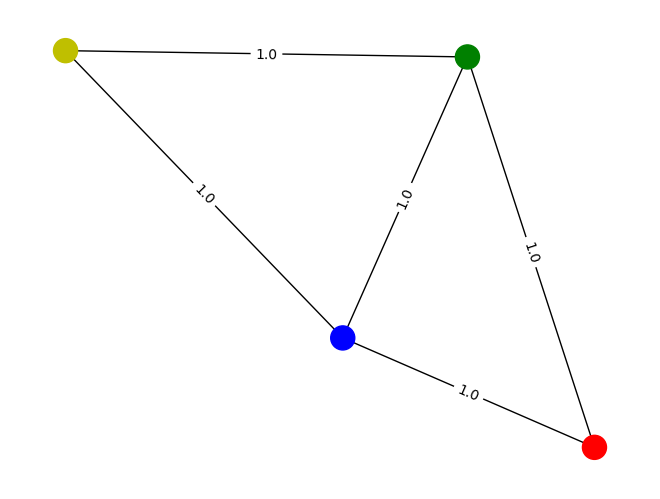

In [24]:
layout = nx.random_layout(G, seed=10)
colors = ['r', 'g', 'b', 'y']
nx.draw(G, layout, node_color=colors)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels);

In [25]:
def objective_value(x: np.ndarray, w: np.ndarray) -> float:
    """Compute the value of a cut.
    Args:
        x: Binary string as numpy array.
        w: Adjacency matrix.
    Returns:
        Value of the cut.
    """
    X = np.outer(x, (1 - x))
    w_01 = np.where(w != 0, 1, 0)
    return np.sum(w_01 * X)

def bitfield(n: int, L: int) -> list[int]:
    result = np.binary_repr(n, L)
    return [int(digit) for digit in result]  # [2:] to chop off the "0b" part

# use the brute-force way to generate the oracle
L = num_nodes
max = 2**L
sol = np.inf
for i in range(max):
    cur = bitfield(i, L)

    how_many_nonzero = np.count_nonzero(cur)
    if how_many_nonzero * 2 != L:  # not balanced
        continue

    cur_v = objective_value(np.array(cur), w)
    if cur_v < sol:
        sol = cur_v

print(f'Objective value computed by the brute-force method is {sol}')

Objective value computed by the brute-force method is 3


In [26]:
from qiskit.quantum_info import Pauli, SparsePauliOp

def get_operator(weight_matrix: np.ndarray) -> tuple[SparsePauliOp, float]:
    r"""Generate Hamiltonian for the graph partitioning
    Notes:
        Goals:
            1 Separate the vertices into two set of the same size.
            2 Make sure the number of edges between the two set is minimized.
        Hamiltonian:
            H = H_A + H_B
            H_A = sum\_{(i,j)\in E}{(1-ZiZj)/2}
            H_B = (sum_{i}{Zi})^2 = sum_{i}{Zi^2}+sum_{i!=j}{ZiZj}
            H_A is for achieving goal 2 and H_B is for achieving goal 1.
    Args:
        weight_matrix: Adjacency matrix.
    Returns:
        Operator for the Hamiltonian
        A constant shift for the obj function.
    """
    num_nodes = len(weight_matrix)
    pauli_list = []
    coeffs = []
    shift = 0

    for i in range(num_nodes):
        for j in range(i):
            if weight_matrix[i, j] != 0:
                x_p = np.zeros(num_nodes, dtype=bool)
                z_p = np.zeros(num_nodes, dtype=bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append(Pauli((z_p, x_p)))
                coeffs.append(-0.5)
                shift += 0.5

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                x_p = np.zeros(num_nodes, dtype=bool)
                z_p = np.zeros(num_nodes, dtype=bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append(Pauli((z_p, x_p)))
                coeffs.append(1.0)
            else:
                shift += 1

    return SparsePauliOp(pauli_list, coeffs=coeffs), shift

qubit_op, offset = get_operator(w)

In [27]:
from qiskit.opflow import I, X, Y, Z
from qiskit.opflow import PauliOp


def QAOA_mixer(n_qubits, name="standard", trot=2, gap=3):
    mixer = 0
    if name == "standard":
        for i in range(n_qubits):
            pauli_str = ["I" for i in range(n_qubits)]
            pauli_str[i] = "X"
            paulis = Pauli("".join(pauli_str))
            mixer += PauliOp(paulis)

    elif name == "ring":
        mixer = 0
        pauli_str = [["I" for i in range(n_qubits)] for i in range(2 * n_qubits * trot)]
        for i in range(n_qubits - 1):
            for j in range(trot):
                pauli_str[2 * i * trot + 2 * j][i] = "X"
                pauli_str[2 * i * trot + 2 * j][i + 1] = "X"
                pauli_str[2 * i * trot + 2 * j + 1][i] = "Y"
                pauli_str[2 * i * trot + 2 * j + 1][i + 1] = "Y"
        for j in range(trot):
            pauli_str[2 * (n_qubits - 1) * trot + 2 * j][0] = "X"
            pauli_str[2 * (n_qubits - 1) * trot + 2 * j][-1] = "X"
            pauli_str[2 * (n_qubits - 1) * trot + 2 * j + 1][0] = "Y"
            pauli_str[2 * (n_qubits - 1) * trot + 2 * j + 1][-1] = "Y"
        for strs in pauli_str:
            mixer += PauliOp(Pauli("".join(strs)), coeff=1 / trot)

    elif name == "par_ring":
        mixer = 0
        pauli_str = [["I" for i in range(n_qubits)] for i in range(2 * n_qubits * trot)]
        half = np.floor(n_qubits / 2)
        for i in range(half):
            for j in range(trot):
                k = i + gap
                if i + gap > n_qubits - 1:
                    k = i + gap - n_qubits - 1
                pauli_str[2 * i * trot + 2 * j][i] = "X"
                pauli_str[2 * i * trot + 2 * j][k] = "X"
                pauli_str[2 * i * trot + 2 * j + 1][i] = "Y"
                pauli_str[2 * i * trot + 2 * j + 1][k] = "Y"

        for strs in pauli_str:
            mixer += PauliOp(Pauli("".join(strs)), coeff=1 / trot)

    elif name == "gap_ring":
        mixer = 0
        pauli_str = [["I" for i in range(n_qubits)] for i in range(2 * n_qubits * trot)]
        for i in range(n_qubits):
            for j in range(trot):
                k = i + gap
                if i + gap > n_qubits - 1:
                    k = i + gap - n_qubits - 1
                pauli_str[2 * i * trot + 2 * j][i] = "X"
                pauli_str[2 * i * trot + 2 * j][k] = "X"
                pauli_str[2 * i * trot + 2 * j + 1][i] = "Y"
                pauli_str[2 * i * trot + 2 * j + 1][k] = "Y"

        for strs in pauli_str:
            mixer += PauliOp(Pauli("".join(strs)), coeff=1 / trot)

    elif name == "full":
        pass

    return mixer


print(QAOA_mixer(4, name="ring"))

0.5 * XXII
+ 0.5 * YYII
+ 0.5 * XXII
+ 0.5 * YYII
+ 0.5 * IXXI
+ 0.5 * IYYI
+ 0.5 * IXXI
+ 0.5 * IYYI
+ 0.5 * IIXX
+ 0.5 * IIYY
+ 0.5 * IIXX
+ 0.5 * IIYY
+ 0.5 * XIIX
+ 0.5 * YIIY
+ 0.5 * XIIX
+ 0.5 * YIIY


Objective value computed by QAOA is 2


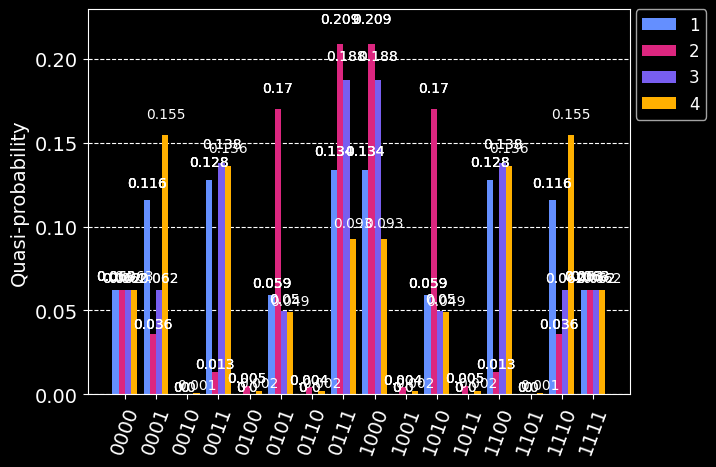

In [43]:
from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.primitives import Sampler
from qiskit.quantum_info import Pauli, Statevector
from qiskit.result import QuasiDistribution
from qiskit.utils import algorithm_globals
from qiskit.opflow import I, Z, X
from qiskit.visualization import plot_histogram

sampler = Sampler()


def sample_most_likely(state_vector: QuasiDistribution | Statevector) -> np.ndarray:
    """Compute the most likely binary string from state vector.
    Args:
        state_vector: State vector or quasi-distribution.

    Returns:
        Binary string as an array of ints.
    """
    if isinstance(state_vector, QuasiDistribution):
        values = list(state_vector.values())
    else:
        values = state_vector
    n = int(np.log2(len(values)))
    k = np.argmax(np.abs(values))
    x = bitfield(k, n)
    x.reverse()
    return np.asarray(x)

algorithm_globals.random_seed = 10598

optimizer = COBYLA(maxiter=200)
OperatorXY = X.compose(X)

eval_count1 = []
def store_values(eval_count, parameters, mean, std):
    eval_count1.append(std)
    values.append(mean)

mixers = [QAOA_mixer(n_qubits=num_nodes, name='ring', trot=i) for i in range(1, 5)]
call_back_value=[]
eigen = []
for mixer in mixers:
    values = []
    qaoa = QAOA(sampler, optimizer, reps=5, callback=store_values, mixer=mixer)
    result = qaoa.compute_minimum_eigenvalue(qubit_op)
    call_back_value.append(values)
    states = {}
    for i in range(2**num_nodes):
        a = f"{bin(i)[2:]:0>{num_nodes}}"
        states[a] = result.eigenstate[i]
    eigen.append(states)

x = sample_most_likely(result.eigenstate)

print(f'Objective value computed by QAOA is {objective_value(x, w)}')

plot_histogram(eigen, legend=['1', '2', '3', '4'])

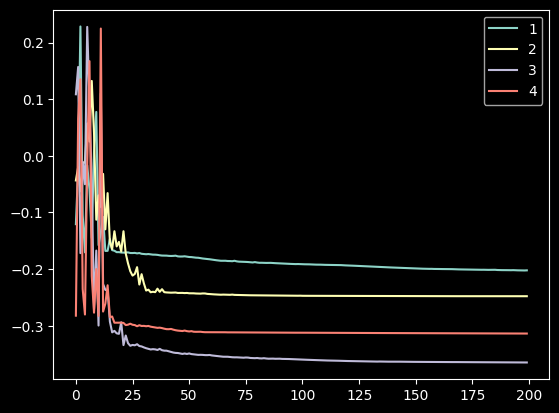

In [37]:
import matplotlib.pyplot as plt
for values in call_back_value:
    plt.plot(values)
plt.legend(['1', '2', '3', '4'])